In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *

import numpy as np

dim=100
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)
A = mk_laplace_1d(dim)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =100
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 125 dim problem using op func. ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-11 19:16:00 [INFO] <ipython-input-4-f8644901a075> 2 - Benchmark 125 dim problem using op func. 


In [5]:
# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,blist,reslist,Err_list,refine):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *



ML_GMRES_Time_list=[] 
Err_list=[]


trainTime_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_time_list=[]

run_time_ML_listP1=[]
run_time_ML_listP2=[]

GmresRunTimeOriginal=[]
GmresRunTimeOriginal_2=[]


debug=True

blist=[]
reslist=[]

refine1=False
refine2=True

for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
    b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,blist,reslist,Err_list,refine1)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    trainTime_list.append(OutList1[2])
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    

#     ML_Out2,run_time2_ML=GMRES_timed(A, b/b_norm, Out[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,blist,reslist,Err_list,refine2)  # normalize b for optimal NN performance.
    Out=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    
    run_time_ML_listP1.append(run_time1_ML)
    run_time_ML_listP2.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    GmresRunTimeOriginal.append(run_time1)
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time_list.append(run_time1+run_time2)
    GmresRunTimeOriginal_2.append(run_time2)

    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 2496.873046875
parameters 20000
Initial Training
2
size 52
0.01892179857012743 0.27825006880901076
0.16951786298886873 0.35672819850151427 0.01892179857012743 0.17832109407587465
0.16951786298886873 0.35672819850151427 0.01892179857012743 0.17832109407587465
3
size 52
0.03859932123475738 0.27825006880901076
0.241122344014002 0.26632395799970254 0.03859932123475738 0.09345880941563695
0.241122344014002 0.26632395799970254 0.03859932123475738 0.09345880941563695
4
size 52
0.014243213984416385 0.27825006880901076
0.25368487800005823 0.25792342000446905 0.014243213984416385 0.07517231335534376
0.25368487800005823 0.25792342000446905 0.014243213984416385 0.07517231335534376
5
size 52
0.12344275683437765 0.27825006880901076
0.23735332902288064 0.22144169500097632 0.12344275683437765 0.023921444596433732
0.23735332902288064 0.22144169500097632 0.12344275683437765 0.023921444596433732
6
size 52
0.044169184000881205 0.27825006880901076
0.17396371500217356 0.2254196035064524 0.04

41
size 52
0.20665123664632573 0.27825006880901076
0.3263505460054148 0.26083391344291157 0.20665123664632573 0.12255248891569405
0.3263505460054148 0.26083391344291157 0.20665123664632573 0.12255248891569405
42
size 52
0.12916535944825608 0.27825006880901076
0.18299119800212793 0.2630955538433045 0.12916535944825608 0.12268430577497157
0.18299119800212793 0.2630955538433045 0.12916535944825608 0.12268430577497157
43
size 52
0.027844541910270887 0.27825006880901076
0.16271309601143003 0.2618568886432331 0.027844541910270887 0.12729104545444264
0.16271309601143003 0.2618568886432331 0.027844541910270887 0.12729104545444264
44
size 52
0.03585102764259529 0.27825006880901076
0.23301300199818797 0.2612216020037886 0.03585102764259529 0.1271198067107387
0.23301300199818797 0.2612216020037886 0.03585102764259529 0.1271198067107387
45
size 52
0.0748988650580869 0.27825006880901076
0.23603651698795147 0.2620202371629421 0.0748988650580869 0.12685629407640134
0.23603651698795147 0.2620202371629

0.3216579370200634 0.25988565223873594 0.08692561161350099 0.10473801530557189
0.3216579370200634 0.25988565223873594 0.08692561161350099 0.10473801530557189
81
size 52
0.006803287389480203 0.27825006880901076
0.15314954798668623 0.2653867868403904 0.006803287389480203 0.10759063425074328
0.15314954798668623 0.2653867868403904 0.006803287389480203 0.10759063425074328
82
size 52
0.04922301149741282 0.27825006880901076
0.195305728004314 0.2640939618390985 0.04922301149741282 0.10739654159708385
0.195305728004314 0.2640939618390985 0.04922301149741282 0.10739654159708385
83
size 52
0.19263797766236715 0.27825006880901076
0.2998099100077525 0.2645793965202756 0.19263797766236715 0.1090831901712589
0.2998099100077525 0.2645793965202756 0.19263797766236715 0.1090831901712589
84
size 52
0.20478665057272244 0.27825006880901076
0.32569971701013856 0.2677748850407079 0.20478665057272244 0.11192460983067373
0.32569971701013856 0.2677748850407079 0.20478665057272244 0.11192460983067373
85
size 52


2020-06-11 19:18:22 [INFO] <ipython-input-6-f3713112f158> 82 - Runtime of Non-decorated version is:
2020-06-11 19:18:22 [INFO] <ipython-input-6-f3713112f158> 83 - 60.035501854203176
2020-06-11 19:18:22 [INFO] <ipython-input-6-f3713112f158> 85 - Runtime of MLGMRES decorator is:
2020-06-11 19:18:22 [INFO] <ipython-input-6-f3713112f158> 86 - 66.6259280158556
2020-06-11 19:18:22 [INFO] <ipython-input-6-f3713112f158> 89 - Runtime of training (backprop) is:
2020-06-11 19:18:22 [INFO] <ipython-input-6-f3713112f158> 90 - 0.0


99


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

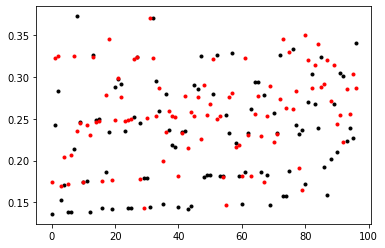

In [8]:
pp.plot(run_time_ML_listP2[3:],'.k',GmresRunTimeOriginal_2[3:],'.r')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


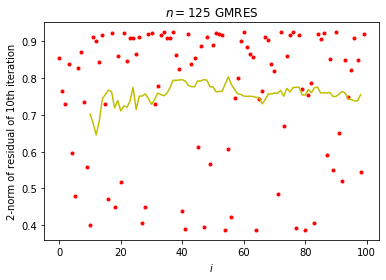

In [9]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=125$ GMRES')
pp.savefig('GMRES.png')

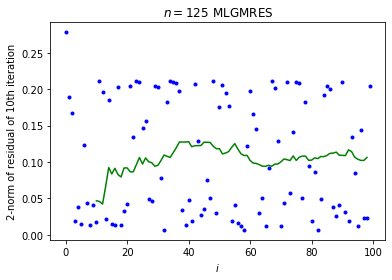

In [10]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=125$ MLGMRES')
pp.savefig('MLGMRES.png')

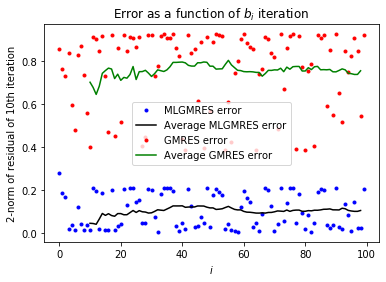

In [11]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

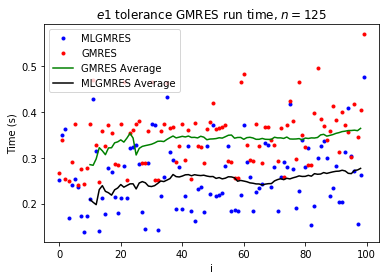

In [12]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')
pp.savefig('Runtime.png')